In [363]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn import tree
from sklearn import datasets
from sklearn.datasets import make_moons ## sklearn functions for synthetic data
from sklearn.datasets import make_circles
from sklearn.decomposition import PCA  ## sklearn PCA classes
from sklearn.decomposition import KernelPCA
from sklearn import linear_model    ## sklearn linear model
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier ## sklearn decision trees
from sklearn.ensemble import RandomForestClassifier ## sklearn random forests 
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_lfw_people 
from sklearn.metrics import classification_report 
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict

#import pydotplus # don't remember whats that
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#pd.reset_option('all')

In [2]:
pd.set_option('display.max_columns', None)

In [4]:
file = pd.read_csv('AQ_with311_seasonal_CD.csv')
file = file.drop(columns=['Unnamed: 0'])

In [5]:
file.head()

,UniqueID,IndicatorID,Name,Measure,MeasureInfo,GeoTypeName,GeoJoinID,GeoPlaceName,Year,Season,Start_Date,DataValue,Total AQ Complaints,"Air: Dust, Commercial (AE2)","Air: Dust, Construction/Demolition (AE4)","Air: Dust, Other (Use Comments) (AE5)","Air: Dust, Residential (AE1)","Air: Odor, Nail Salon (AD8)","Air: Odor, Sweet From Unknown Source (AZ1)","Air: Odor/Fumes, Dry Cleaners (AD1)","Air: Odor/Fumes, Other (Use Comments) (AD6)","Air: Odor/Fumes, Private Carting (AD4)","Air: Odor/Fumes, Restaurant (AD2)","Air: Odor/Fumes, Vehicle Idling (AD3)","Air: Open Fire, Commercial (AC2)","Air: Open Fire, Construction/Demolition (AC4)","Air: Open Fire, Residential (AC1)",Air: Other Air Problem (Use Comments) (AZZ),"Air: Smoke, Chimney or vent (AS1)","Air: Smoke, Commercial (AA2)","Air: Smoke, Other (Use Comments) (AA5)","Air: Smoke, Residential (AA1)","Air: Smoke, Vehicular (AA4)","Air: Soot, Other (Use Comments) (AB4)"
0,169573,365,Fine Particulate Matter (PM2.5),Mean,mcg per cubic meter,CD,503,Tottenville and Great Kills (CD3),2013,Summer,06/01/2013,9.13,10,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,3.0,NaN
1,166918,375,Nitrogen Dioxide (NO2),Mean,ppb,CD,503,Tottenville and Great Kills (CD3),2013,Summer,06/01/2013,7.59,10,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,3.0,NaN
2,216630,386,Ozone (O3),Mean,ppb,CD,503,Tottenville and Great Kills (CD3),2013,Summer,06/01/2013,32.64,10,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,3.0,NaN
3,547775,365,Fine Particulate Matter (PM2.5),Mean,mcg per cubic meter,CD,503,Tottenville and Great Kills (CD3),2017,Winter,12/01/2016,6.87,138,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,2.0,115.0,NaN,NaN,NaN,4.0,NaN
4,550167,375,Nitrogen Dioxide (NO2),Mean,ppb,CD,503,Tottenville and Great Kills (CD3),2017,Winter,12/01/2016,17.47,138,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,2.0,115.0,NaN,NaN,NaN,4.0,NaN


In [6]:
file.columns

Index(['UniqueID', 'IndicatorID', 'Name', 'Measure', 'MeasureInfo',
       'GeoTypeName', 'GeoJoinID', 'GeoPlaceName', 'Year', 'Season',
       'Start_Date', 'DataValue', 'Total AQ Complaints',
       'Air: Dust, Commercial (AE2)',
       'Air: Dust, Construction/Demolition (AE4)',
       'Air: Dust, Other (Use Comments) (AE5)', 'Air: Dust, Residential (AE1)',
       'Air: Odor, Nail Salon (AD8)',
       'Air: Odor, Sweet From Unknown Source (AZ1)',
       'Air: Odor/Fumes, Dry Cleaners (AD1)',
       'Air: Odor/Fumes, Other (Use Comments) (AD6)',
       'Air: Odor/Fumes, Private Carting (AD4)',
       'Air: Odor/Fumes, Restaurant (AD2)',
       'Air: Odor/Fumes, Vehicle Idling (AD3)',
       'Air: Open Fire, Commercial (AC2)',
       'Air: Open Fire, Construction/Demolition (AC4)',
       'Air: Open Fire, Residential (AC1)',
       'Air: Other Air Problem (Use Comments) (AZZ)',
       'Air: Smoke, Chimney or vent (AS1)', 'Air: Smoke, Commercial (AA2)',
       'Air: Smoke, Other (Use C

In [7]:
ct = file.loc[:, 'Air: Dust, Commercial (AE2)':'Air: Soot, Other (Use Comments) (AB4)']
print('Number of different complaint types: {}'.format(len(ct.columns)))
print('Number of different years: {} (from {} to {})'.format(len(file.Year.unique()), file.Year.min(), file.Year.max()))
print('Number of different Community Districts (CD): {}'.format(len(file.GeoJoinID.unique())))

Number of different complaint types: 21
Number of different years: 9 (from 2010 to 2018)
Number of different Community Districts (CD): 59


### Calculating 75th percentile of pollutants to create thresholds for logisitc regression

In [201]:
pm25_thres = np.percentile(file.loc[file['IndicatorID'] == 365]['DataValue'],75)
no2_thres = np.percentile(file.loc[file['IndicatorID'] == 375]['DataValue'],75)
o3_thres = np.percentile(file.loc[file['IndicatorID'] == 386]['DataValue'],75)
so2_thres = np.percentile(file.loc[file['IndicatorID'] == 383]['DataValue'],75)
print('PM2.5 threshold is:',pm25_thres,'mcg per cubic meter')
print('NO2 threshold is:',no2_thres,'ppb')
print('O3 threshold is:',o3_thres,'ppb')
print('SO2 threshold is:',so2_thres,'ppb')

PM2.5 threshold is: 11.3975 mcg per cubic meter
NO2 threshold is: 26.505 ppb
O3 threshold is: 32.995000000000005 ppb
SO2 threshold is: 3.24 ppb


In [263]:
file['Above Threshold'] = 1 #True
for i in range(len(file)):
    if (file['IndicatorID'][i] == 365) & (file['DataValue'][i] < pm25_thres):
        file['Above Threshold'][i] = 0 #False
    elif (file['IndicatorID'][i] == 375) & (file['DataValue'][i] < no2_thres):
        file['Above Threshold'][i] = 0 #False
    elif (file['IndicatorID'][i] == 386) & (file['DataValue'][i] < o3_thres):
        file['Above Threshold'][i] = 0 #False
    elif (file['IndicatorID'][i] == 383) & (file['DataValue'][i] < so2_thres):
        file['Above Threshold'][i] = 0 #False

<ipython-input-263-b007355cf7a1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['Above Threshold'][i] = 0 #False
<ipython-input-263-b007355cf7a1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['Above Threshold'][i] = 0 #False
<ipython-input-263-b007355cf7a1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['Above Threshold'][i] = 0 #False
<ipython-input-263-b007355cf7a1>:10: SettingWithCopyWarning: 
A value is trying

## Initial Discussion

In [265]:
# 0. Define X, y

# 1. Correlation?
# ---- A) all
# ---- b) combinations

# 2. Run simple Linear Regression
# ---- 2.1 without cross-v
# ---- 2.2 with cross-v

# 3. Run simple Logistic Regression
# ---- 2.1 without cross-v
# ---- 2.2 with cross-v

# 4. Run linear PCA
# ---- 3.1 standardize
# ---- 3.2 plot explained variance over nr of components
# ---- 3.3 choose nr. of PCs as regressonrs and run LR

# 5. Run non-linear PCA (kpca)

# 6. Decision Trees/SVM?

# 7. Random Forest

In [266]:
# 0. Define X, y. To discuss:

# target var: file.loc[:, 'DataValue']
# ----------> A) PM2.5
# ----------> B) NO2
# ----------> C) O3 (only summer)
# ----------> D) SO2 (only winter)


# input vars: 
# ----------> A) 'Total AQ Complaints'
# ----------> B) file.loc[:, 'Air: Dust, Commercial (AE2)':'Air: Soot, Other (Use Comments) (AB4)']

## 1. Correlation

### 1.1. All Datavalues together

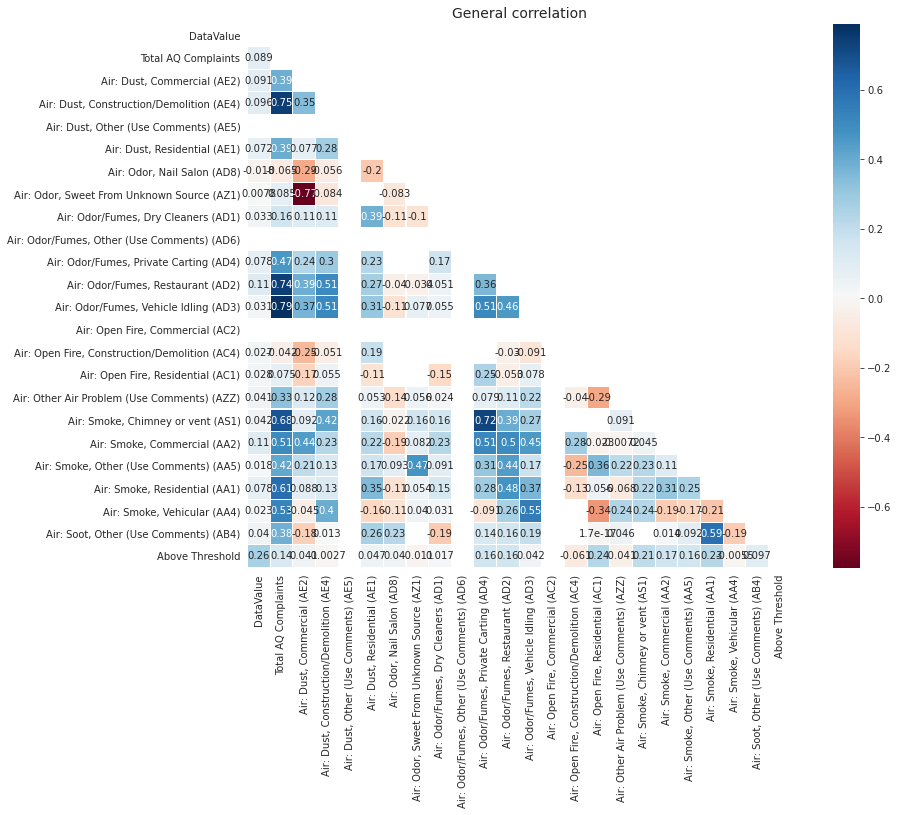

In [267]:
cols = ['UniqueID', 'IndicatorID', 'Name', 'Measure', 'MeasureInfo','GeoTypeName', 'GeoJoinID', 'GeoPlaceName', 'Year', 'Season','Start_Date']
mask = np.zeros_like(file.drop(columns=cols).corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(file.drop(columns=cols).corr(), annot=True, linewidths=.1, cmap="RdBu", mask=mask, square=True)
    ax.set_title('General correlation', fontsize=14)

### 1.2 By indicator

IndicatorID - Name
- 365 - PM2.5
- 375 - NO2
- 386 - O3
- 383 - SO2

In [268]:
file_pm25 = file.loc[file['IndicatorID'] == 365]
file_no2 = file.loc[file['IndicatorID'] == 375]
file_o3 = file.loc[file['IndicatorID'] == 386]
file_so2 = file.loc[file['IndicatorID'] == 383]

In [269]:
def corr_matrix(filename, pollutant):
    columns = ['UniqueID', 'IndicatorID', 'Name', 'Measure', 'MeasureInfo','GeoTypeName', 'GeoJoinID', 'GeoPlaceName', 'Year', 'Season','Start_Date']
    mask = np.zeros_like(file.drop(columns=columns).corr())
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(15, 10))
        ax = sns.heatmap(filename.drop(columns=columns).corr(), annot=True, linewidths=.1, cmap="RdBu", mask=mask, square=True)
        ax.set_title(pollutant, fontsize=14)

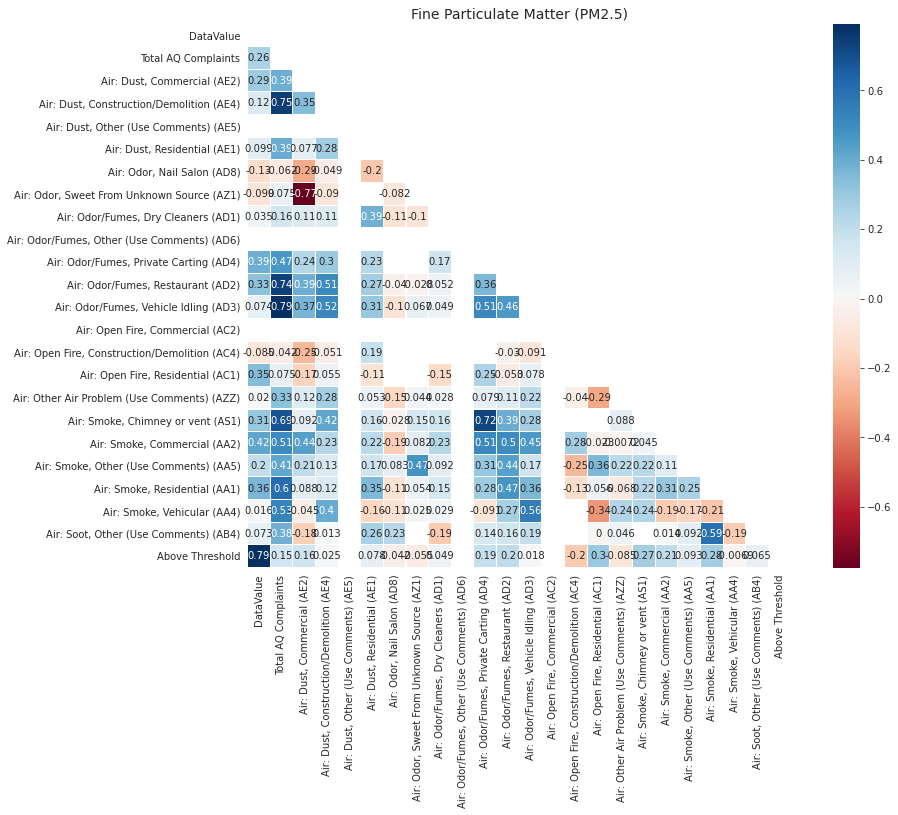

In [270]:
corr_matrix(file_pm25, 'Fine Particulate Matter (PM2.5)')

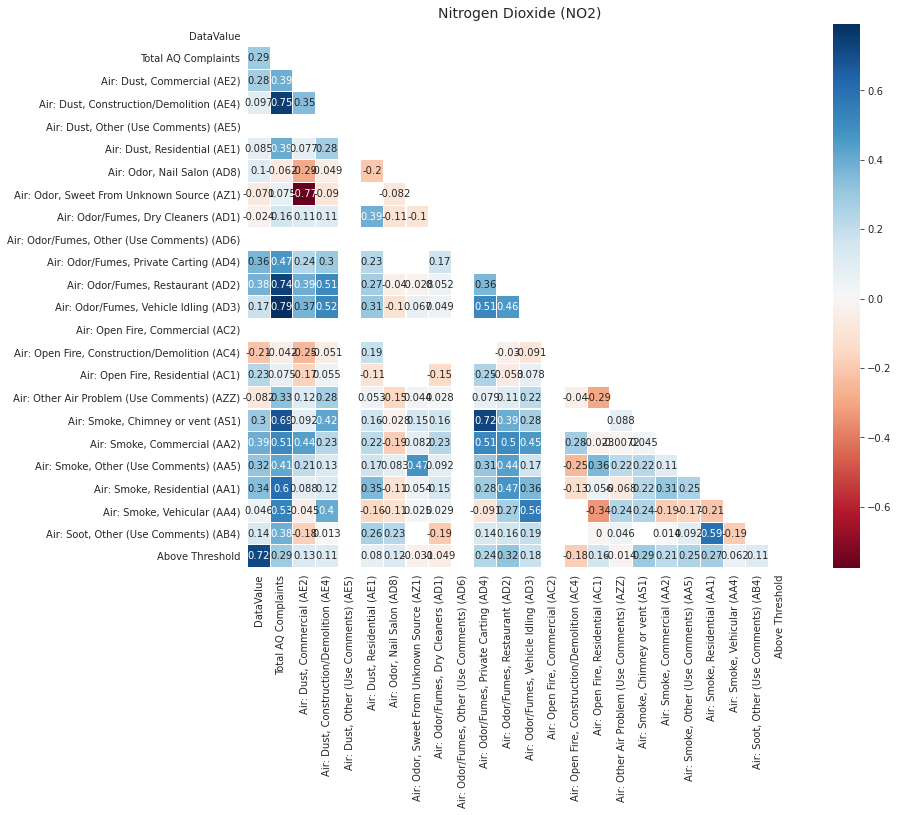

In [271]:
corr_matrix(file_no2, 'Nitrogen Dioxide (NO2)')

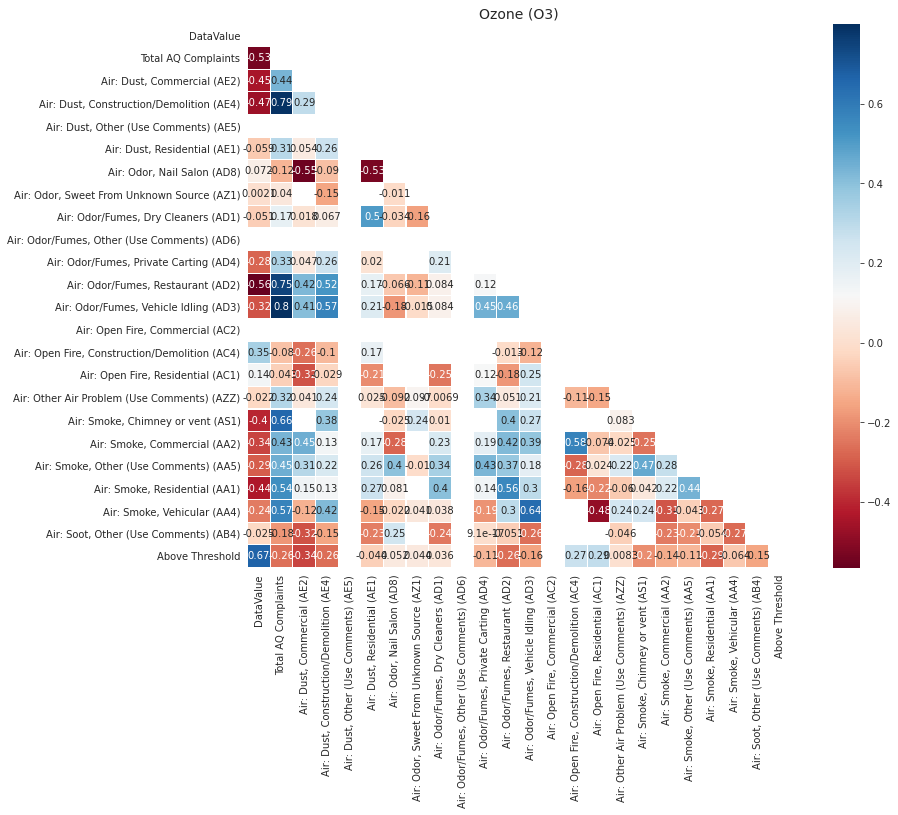

In [272]:
corr_matrix(file_o3, 'Ozone (O3)')

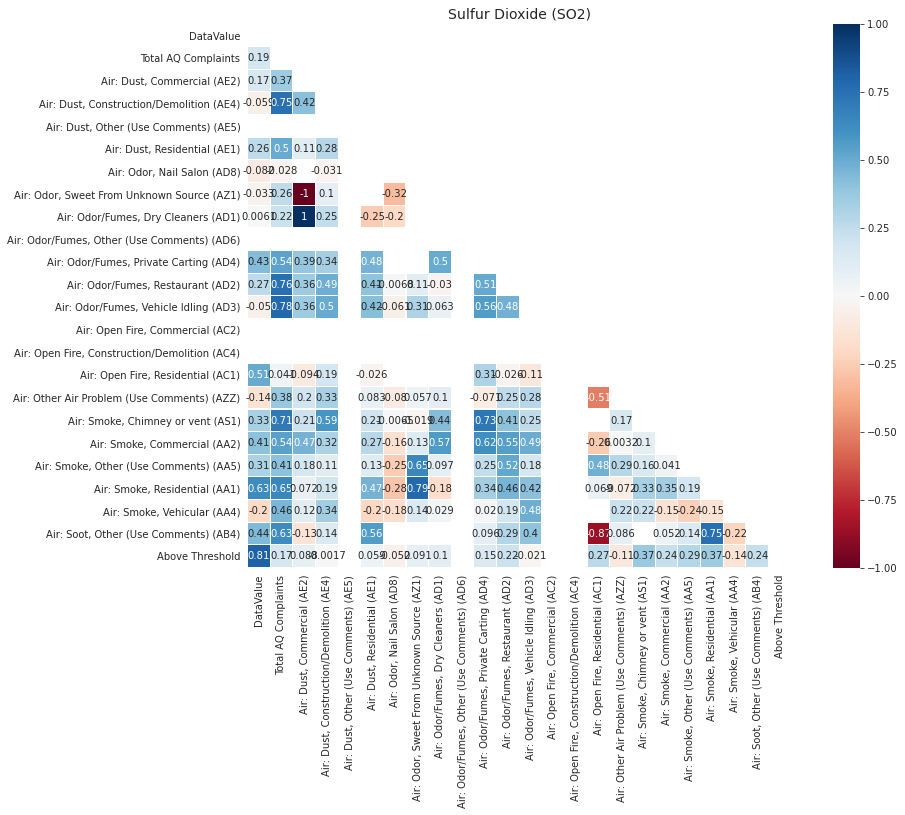

In [273]:
corr_matrix(file_so2, 'Sulfur Dioxide (SO2)')

## 2. Simple Linear Regression

In [274]:
# replace NaNs with 0 for correct implementation of LR

file_pm25 = file_pm25.fillna(0)
file_no2 = file_no2.fillna(0)
file_o3 = file_o3.fillna(0)
file_so2 = file_so2.fillna(0)

In [275]:
# function to print LR-results and variables with p<0.05
def LR_results(lm):
    print("R-squared: {:.2f}".format(lm.rsquared))
    print()
    print()
    print("Regressor: Coefficient")
    print()
    for v, i, p in zip(lm.pvalues, lm.pvalues.index, lm.params):
        if v < 0.05:
            print("{}: {:.2f}".format(i, p))

            
# function to apply cross validation to detect overfitting            
def cross_validation(data_x, Y): # without intercept
    np.random.seed(2018)
    R_IS=[]; R_OS=[] 
    n=100 

    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(data_x,Y,test_size=0.3)
        res=sm.OLS(y_train,X_train).fit()
        R_IS.append(res.rsquared)   
        y_pred=res.predict(X_test)
        R_OS.append(r2_score(y_test,y_pred))
    print("Linear regression WITHOUT intercept")
    print("IS R-squared is %.3f+-%.3f"%(np.mean(R_IS),np.std(R_IS)))
    print("OS R-squared is %.3f+-%.3f"%(np.mean(R_OS),np.std(R_OS)))
    
def cross_validation_interc(data_x, Y): # with intercept
    np.random.seed(2018)
    R_IS=[]; R_OS=[] 
    n=100 

    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(data_x),Y,test_size=0.3)
        res=sm.OLS(y_train,X_train).fit()
        R_IS.append(res.rsquared)   
        y_pred=res.predict(X_test)
        R_OS.append(r2_score(y_test,y_pred))
    print("Linear regression WITH intercept")
    print("IS R-squared is %.3f+-%.3f"%(np.mean(R_IS),np.std(R_IS)))
    print("OS R-squared is %.3f+-%.3f"%(np.mean(R_OS),np.std(R_OS)))

### 2.1 Indicator = PM2.5

#### 2.1.1 X-Columns: all (Total AQ complaints + all complaints by type)

In [276]:
## without intercept

In [277]:
data_x = file_pm25.iloc[:,12:-1]
Y = file_pm25.DataValue
lm = sm.OLS(Y,data_x).fit() 

In [278]:
LR_results(lm)

R-squared: 0.69


Regressor: Coefficient

Total AQ Complaints: 0.59
Air: Dust, Construction/Demolition (AE4): -0.49
Air: Dust, Residential (AE1): 0.52
Air: Odor, Nail Salon (AD8): 0.51
Air: Odor/Fumes, Other (Use Comments) (AD6): -0.00
Air: Odor/Fumes, Restaurant (AD2): -0.57
Air: Odor/Fumes, Vehicle Idling (AD3): -0.56
Air: Smoke, Chimney or vent (AS1): -0.56
Air: Smoke, Commercial (AA2): -0.57
Air: Smoke, Other (Use Comments) (AA5): -0.33
Air: Smoke, Residential (AA1): -0.58
Air: Smoke, Vehicular (AA4): -0.41


In [279]:
cross_validation(data_x, Y)

Linear regression WITHOUT intercept
IS R-squared is 0.694+-0.008
OS R-squared is -9.671+-0.948


In [280]:
## with intercept

In [281]:
data_x = file_pm25.iloc[:,12:-1]
Y = file_pm25.DataValue
lm = sm.OLS(Y,sm.add_constant(data_x)).fit()

In [282]:
LR_results(lm)

R-squared: 0.31


Regressor: Coefficient

const: 9.65
Total AQ Complaints: 0.09
Air: Dust, Commercial (AE2): 0.22
Air: Dust, Construction/Demolition (AE4): -0.08
Air: Dust, Other (Use Comments) (AE5): 0.00
Air: Odor, Nail Salon (AD8): -0.20
Air: Odor, Sweet From Unknown Source (AZ1): -0.36
Air: Odor/Fumes, Dry Cleaners (AD1): -0.22
Air: Odor/Fumes, Restaurant (AD2): -0.06
Air: Odor/Fumes, Vehicle Idling (AD3): -0.10
Air: Open Fire, Construction/Demolition (AC4): 0.54
Air: Other Air Problem (Use Comments) (AZZ): -0.09
Air: Smoke, Chimney or vent (AS1): -0.08
Air: Smoke, Residential (AA1): -0.08
Air: Smoke, Vehicular (AA4): -0.11


In [283]:
cross_validation(data_x, Y)

Linear regression WITHOUT intercept
IS R-squared is 0.694+-0.008
OS R-squared is -9.671+-0.948


#### 2.1.2 X-Columns: complaints by type

In [284]:
# WITHOUT INTERCEPT

In [285]:
data_x = file_pm25.iloc[:,13:-1]
Y = file_pm25.DataValue
lm = sm.OLS(Y,data_x).fit()

In [286]:
LR_results(lm)

R-squared: 0.69


Regressor: Coefficient

Air: Dust, Commercial (AE2): 1.05
Air: Dust, Construction/Demolition (AE4): 0.10
Air: Dust, Residential (AE1): 1.12
Air: Odor, Nail Salon (AD8): 1.11
Air: Odor, Sweet From Unknown Source (AZ1): 1.01
Air: Odor/Fumes, Vehicle Idling (AD3): 0.03
Air: Open Fire, Commercial (AC2): 2.91
Air: Other Air Problem (Use Comments) (AZZ): 0.45
Air: Smoke, Chimney or vent (AS1): 0.03
Air: Smoke, Other (Use Comments) (AA5): 0.26
Air: Smoke, Vehicular (AA4): 0.19


In [287]:
cross_validation(data_x, Y)

Linear regression WITHOUT intercept
IS R-squared is 0.694+-0.008
OS R-squared is -9.671+-0.948


In [288]:
# WITH INTERCEPT

In [289]:
data_x = file_pm25.iloc[:,13:-1]
Y = file_pm25.DataValue
lm = sm.OLS(Y,sm.add_constant(data_x)).fit()

In [290]:
LR_results(lm)

R-squared: 0.31


Regressor: Coefficient

const: 9.65
Air: Dust, Commercial (AE2): 0.31
Air: Dust, Construction/Demolition (AE4): 0.01
Air: Dust, Other (Use Comments) (AE5): -0.00
Air: Dust, Residential (AE1): 0.14
Air: Odor, Nail Salon (AD8): -0.11
Air: Odor, Sweet From Unknown Source (AZ1): -0.27
Air: Odor/Fumes, Other (Use Comments) (AD6): 0.00
Air: Odor/Fumes, Private Carting (AD4): 0.21
Air: Odor/Fumes, Restaurant (AD2): 0.03
Air: Odor/Fumes, Vehicle Idling (AD3): -0.01
Air: Open Fire, Construction/Demolition (AC4): 0.63
Air: Smoke, Chimney or vent (AS1): 0.01
Air: Smoke, Commercial (AA2): 0.07


In [291]:
cross_validation_interc(data_x, Y)

Linear regression WITH intercept
IS R-squared is 0.316+-0.017
OS R-squared is 0.265+-0.052


In [292]:
# conclusion:

# 1. adding intercept gives lower R2 but we encounter less overfitting

# 2. before cross-validation
# ----- same r-squared
# ----- 1st regression: total AQ complaints explaints about 60% of Y. Some negative and small coefficients for the other variables
# ----- 2nd regression: coefficients are small but positive

# 3. after cross validation:
# ----- sever overfitting encountered

### 2.2 Indicator: O3

#### 2.2.1 X-Columns: all (Total AQ complaints + all complaints by type)

In [293]:
data_x = file_o3.iloc[:,12:-1]
Y = file_o3.DataValue
lm = sm.OLS(Y,sm.add_constant(data_x)).fit()

In [294]:
LR_results(lm)

R-squared: 0.42


Regressor: Coefficient

const: 32.54
Air: Dust, Other (Use Comments) (AE5): 0.00
Air: Dust, Residential (AE1): 0.26
Air: Odor/Fumes, Other (Use Comments) (AD6): -0.00


In [295]:
cross_validation_interc(data_x, Y)

Linear regression WITH intercept
IS R-squared is 0.433+-0.025
OS R-squared is 0.339+-0.082


### 2.3 Indicator: SO2
#### 2.3.1 X-Columns: all (Total AQ complaints + all complaints by type)

In [296]:
data_x = file_so2.iloc[:,12:-1]
Y = file_so2.DataValue
lm = sm.OLS(Y,sm.add_constant(data_x)).fit()

In [297]:
LR_results(lm)

R-squared: 0.56


Regressor: Coefficient

const: 2.14
Total AQ Complaints: 0.08
Air: Dust, Construction/Demolition (AE4): -0.09
Air: Odor/Fumes, Restaurant (AD2): -0.09
Air: Odor/Fumes, Vehicle Idling (AD3): -0.09
Air: Open Fire, Commercial (AC2): 1.33
Air: Other Air Problem (Use Comments) (AZZ): -0.17
Air: Smoke, Vehicular (AA4): -0.11


In [298]:
cross_validation_interc(data_x, Y)

Linear regression WITH intercept
IS R-squared is 0.578+-0.021
OS R-squared is 0.434+-0.136


### 2.4 Indicator: NO2
#### 2.4.1 X-Columns: all (Total AQ complaints + all complaints by type)

In [299]:
data_x = file_no2.iloc[:,12:-1]
Y = file_no2.DataValue
lm = sm.OLS(Y,sm.add_constant(data_x)).fit()

In [300]:
LR_results(lm)

R-squared: 0.25


Regressor: Coefficient

const: 20.67
Air: Dust, Other (Use Comments) (AE5): 0.00
Air: Odor, Sweet From Unknown Source (AZ1): -1.15
Air: Odor/Fumes, Other (Use Comments) (AD6): -0.00
Air: Smoke, Commercial (AA2): 0.37
Air: Smoke, Other (Use Comments) (AA5): 0.38


In [301]:
cross_validation_interc(data_x, Y)

Linear regression WITH intercept
IS R-squared is 0.256+-0.017
OS R-squared is 0.213+-0.041


## 3 Logistic Regression with "Above Threshold" as Target Variable

### 3.1 Indicator: PM2.5

In [434]:
def print_confusion_matrix(y_true, y_pred):
    # Function for printing Confusion matrix, based on labels and predictions
    ls = list(confusion_matrix(y_true, y_pred)) ## returns tn, fp, fn, tp
    ls = pd.DataFrame(ls, columns = ['Predicted Negative', 'Predicted Positive'],
                      index=['Actual Negative', 'Actual Positive'])
    
    #compute TP,FP,FN,TN
    TP = sum((y_pred==1)&(y_true==1))
    FP = sum((y_pred==1)&(y_true==0))
    FN = sum((y_pred==0)&(y_true==1))
    TN = sum((y_pred==0)&(y_true==0))

    #compute precision, accuracy and recall
    Acc = 100.0 * (TP+TN)/(TP+TN+FP+FN)
    Rec = 100.0 * TP/(TP+FN)
    Prec= 100.0 * TP/(TP+FP)
    
    print('LOGISTIC REGRESSION \nErrors={0}\n'.format(sum(y_pred!=Y_test)))
    print('Precision = %.2f%%\nAccuracy = %.2f%%\nRecall = %.2f%%\n'%(Prec,Acc,Rec))
    print ("Confusion Matrix:\n", ls)

In [435]:
# pass the file_pollutant dataframe to this function
data_LR = ()
def logistic_regression(data):
    #Normalizing dataset
    total_data = data.iloc[:,12:-1].sum(axis = 1)
    data_LR = data.iloc[:,12:-1].div(total_data,axis = 0)
    #data_LR = data_LR.loc[total_data>10] do we want to keep CDs with a certain number of complaints only? 
    data_LR = data_LR[data_LR.sum().sort_values().index]
    
    #Standardize
    scaler_data_LR = preprocessing.StandardScaler().fit(data_LR)
    data_LR_S = scaler_data_LR.transform(data_LR)
    
    #Fit Logistic Regression Model & Cross-validate
    data_LR['Above Threshold'] = data['Above Threshold']
    Y = data_LR['Above Threshold']
    X = data_LR_S
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.30, random_state=100)
    model = LogisticRegression(C=1)
    model.fit(X_train, Y_train)
    y_pred = cross_val_predict(model, X_test, Y_test, cv=10)
    return Y_test,y_pred

In [436]:
Y_test,y_pred = logistic_regression(file_pm25)
print_confusion_matrix(Y_test, y_pred)

LOGISTIC REGRESSION 
Errors=62

Precision = 71.67%
Accuracy = 80.56%
Recall = 48.86%

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 214                  17
Actual Positive                  45                  43


### 3.2 Indicator: O3

In [437]:
Y_test,y_pred = logistic_regression(file_o3)
print_confusion_matrix(Y_test, y_pred)

LOGISTIC REGRESSION 
Errors=33

Precision = 61.29%
Accuracy = 79.38%
Recall = 47.50%

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 108                  12
Actual Positive                  21                  19


### 3.3 Indicator: SO2

In [438]:
Y_test,y_pred = logistic_regression(file_so2)
print_confusion_matrix(Y_test, y_pred)

LOGISTIC REGRESSION 
Errors=25

Precision = 66.67%
Accuracy = 79.84%
Recall = 52.94%

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                  81                   9
Actual Positive                  16                  18


### 3.3 Indicator: NO2

In [439]:
Y_test,y_pred = logistic_regression(file_no2)
print_confusion_matrix(Y_test, y_pred)

LOGISTIC REGRESSION 
Errors=85

Precision = 43.59%
Accuracy = 73.35%
Recall = 21.25%

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 217                  22
Actual Positive                  63                  17


#### 3.5.1 X-Columns: all (Total AQ complaints + all complaints by type)

In [257]:
## without intercept

In [258]:
data_x = file_pm25.iloc[:,12:-1]
Y = file_pm25['Above Threshold']
lm = sm.OLS(Y,data_x).fit() 
LR_results(lm)

R-squared: -164.73


Regressor: Coefficient

Total AQ Complaints: 0.02
Air: Dust, Commercial (AE2): 0.08
Air: Dust, Construction/Demolition (AE4): -0.02
Air: Dust, Other (Use Comments) (AE5): -0.00
Air: Dust, Residential (AE1): 0.04
Air: Odor, Sweet From Unknown Source (AZ1): -0.06
Air: Odor/Fumes, Restaurant (AD2): -0.02
Air: Odor/Fumes, Vehicle Idling (AD3): -0.02
Air: Other Air Problem (Use Comments) (AZZ): -0.02
Air: Smoke, Chimney or vent (AS1): -0.02
Air: Smoke, Residential (AA1): -0.02
Air: Smoke, Vehicular (AA4): -0.02
Air: Soot, Other (Use Comments) (AB4): 0.07


In [259]:
#with intercept
data_x = file_pm25.iloc[:,12:-1]
Y = file_pm25['Above Threshold']
lm = sm.OLS(Y,sm.add_constant(data_x)).fit()
LR_results(lm)

R-squared: 0.23


Regressor: Coefficient

const: 0.19
Air: Dust, Commercial (AE2): 0.07
Air: Dust, Residential (AE1): 0.03
Air: Odor, Nail Salon (AD8): -0.03
Air: Odor, Sweet From Unknown Source (AZ1): -0.07
Air: Odor/Fumes, Vehicle Idling (AD3): -0.01
Air: Other Air Problem (Use Comments) (AZZ): -0.02
Air: Soot, Other (Use Comments) (AB4): 0.08


## 4. Linear PCA + LR with PCA

Steps:
1. Check total activity per CD to detect CD with little number of complaints
2. Filter them out from the original df
3. Standardize data
4. Apply PCA
5. Run LR with cross-validation over PCA components

### 4.1. Indicator: PM2.5

#### 4.1.1 X-Columns: all (Total AQ complaints + all complaints by type)

In [45]:
# 1. 
# Check tota activity per cd to see which ones have too little complaints. 
# Eventually drop them

In [46]:
# total 311 activity per cd

data_cd = file_pm25[['GeoJoinID', 'Total AQ Complaints']].groupby(by='GeoJoinID').sum().reset_index()
data_cd.describe()['Total AQ Complaints']

count      59.000000
mean     1104.711864
std       899.826862
min       218.000000
25%       495.000000
50%       805.000000
75%      1320.000000
max      4052.000000
Name: Total AQ Complaints, dtype: float64

<AxesSubplot:xlabel='GeoJoinID'>

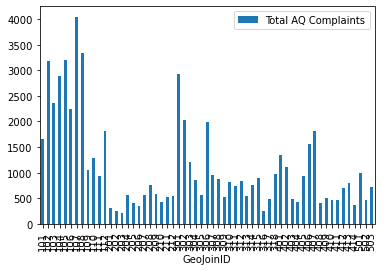

In [47]:
file_pm25[['GeoJoinID', 'Total AQ Complaints']].groupby(by='GeoJoinID').sum().plot.bar()

In [48]:
# 25% threshold
thres = data_cd.describe()['Total AQ Complaints'][4]

In [49]:
# cd with > 500 complaints (which is lower 25% threshold according to previous statistics)
data_cd = data_cd.loc[data_cd['Total AQ Complaints']>thres]

# filter out
file_pm25_sel = file_pm25.loc[file_pm25['GeoJoinID'].isin(data_cd.GeoJoinID.tolist())]

# comparison
print("Previously: {}. After filtering out CD with little amount of complaints: {}".format(len(file_pm25), len(file_pm25_sel)))

Previously: 1062. After filtering out CD with little amount of complaints: 792


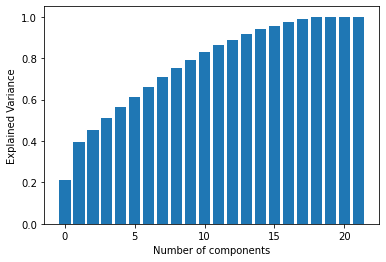

In [50]:
# standardize
data = file_pm25_sel.iloc[:,12:]
data_s = preprocessing.StandardScaler().fit(data).transform(data)  

#perform PC decomposition over data311
pca = PCA(data_s.shape[1]) 
data_p = pca.fit_transform(data_s)
eigenvalues = pca.explained_variance_ratio_

#plot explained variance over the number of compinents
n=data_s.shape[1]
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [51]:
# 10 first leading pca explain 80% of the data

In [52]:
# cross valid WITH intercept

In [53]:
np.random.seed(0)
R_IS=[]; R_OS=[]

X = file_pm25_sel.iloc[:,12:]
Y = file_pm25_sel['DataValue']

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3) # split
    
    scaler = preprocessing.StandardScaler().fit(X_train) # standardize
    pca = PCA(9) # pca components
    P_train=pca.fit_transform(scaler.transform(X_train)) 
    res=sm.OLS(y_train,sm.add_constant(P_train)).fit()  
    P_test=pca.transform(scaler.transform(X_test))
    y_pred=np.asarray(res.predict(sm.add_constant(P_test)))
    
    R_IS.append(res.rsquared)
    R_OS.append(r2_score(y_test,y_pred))
    
    
print("IS R-squared is %.3f+-%.3f"%(np.mean(R_IS),np.std(R_IS)))
print("OS R-squared is %.3f+-%.3f"%(np.mean(R_OS),np.std(R_OS)))

IS R-squared is 0.325+-0.017
OS R-squared is 0.300+-0.046


In [54]:
# very low OS r-squared, although almost no overfitting. But still low value for r2

In [55]:
###############  create functions to run same code for the 3 remaining indicators ###############

In [103]:
# total activity per cd + plot
def total_cd(data):
    data_cd = data[['GeoJoinID', 'Total AQ Complaints']].groupby(by='GeoJoinID').sum().reset_index()
    thres = data_cd.describe()['Total AQ Complaints'][4]
    
    # filter out
    data_cd = data_cd.loc[data_cd['Total AQ Complaints']>thres]
    data_sel = data.loc[data['GeoJoinID'].isin(data_cd.GeoJoinID.tolist())]
    return thres,data,data_sel
    
def print_total_cd(thres,data,data_sel):
    data[['GeoJoinID', 'Total AQ Complaints']].groupby(by='GeoJoinID').sum().plot.bar()
    print('25% threshold: {}'.format(thres))
    # comparison
    print("Previously: {}. After filtering out CD with little amount of complaints: {}".format(len(data),
                                                                                               len(data_sel)))
def pca(data_sel,pollutant):
    
    # standardize
    data = data_sel.iloc[:,12:]
    data_s = preprocessing.StandardScaler().fit(data).transform(data)  

    #perform PC decomposition over data311
    pca = PCA(data_s.shape[1]) 
    data_p = pca.fit_transform(data_s)
    eigenvalues = pca.explained_variance_ratio_

    #plot explained variance over the number of compinents
    n=data_s.shape[1]
    plt.bar(np.arange(n), eigenvalues[:n].cumsum())
    plt.title(str(pollutant))
    plt.xlabel("Number of components")
    plt.ylabel("Explained Variance")
    plt.show()

25% threshold: 495.0
Previously: 1062. After filtering out CD with little amount of complaints: 792


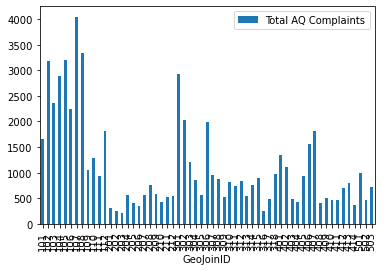

In [104]:
thres,data,data_sel = total_cd(file_pm25)
print_total_cd(thres,data,data_sel)

25% threshold: 288.5
Previously: 531. After filtering out CD with little amount of complaints: 396


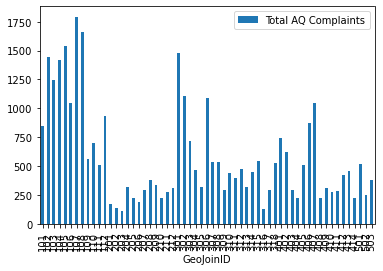

In [97]:
thres,data,data_sel = total_cd(file_o3)
print_total_cd(thres,data,data_sel)

25% threshold: 495.0
Previously: 1062. After filtering out CD with little amount of complaints: 792


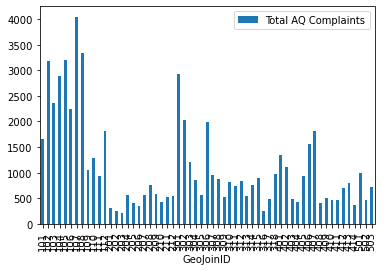

In [98]:
thres,data,data_sel = total_cd(file_no2)
print_total_cd(thres,data,data_sel)

25% threshold: 166.5
Previously: 413. After filtering out CD with little amount of complaints: 308


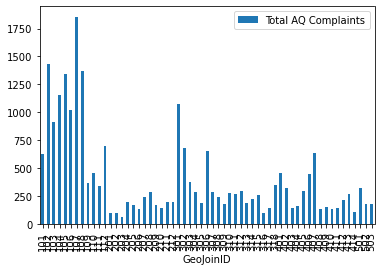

In [99]:
thres,data,data_sel = total_cd(file_so2)
print_total_cd(thres,data,data_sel)

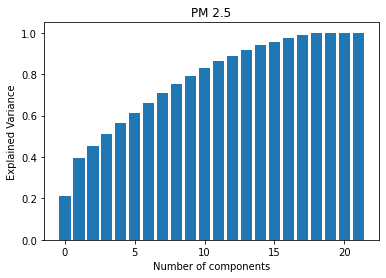

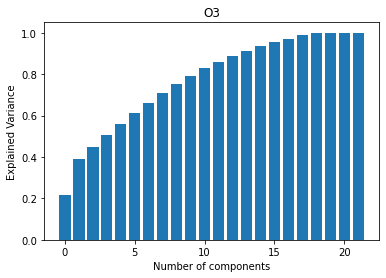

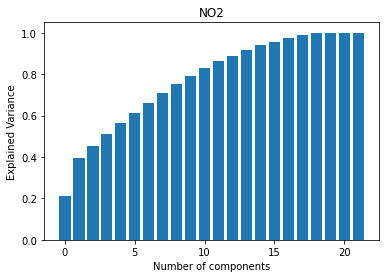

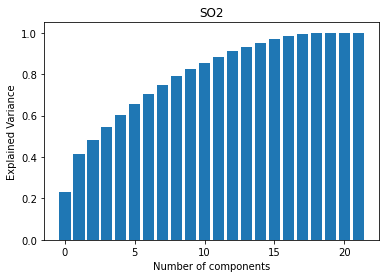

In [100]:
pollutant_dict = {'PM 2.5':file_pm25, 'O3':file_o3, 'NO2':file_no2, 'SO2':file_so2}
for pollutant in pollutant_dict:
    thres,data,data_sel = total_cd(pollutant_dict[pollutant])
    pca(data_sel,pollutant)